TODOs

* check whether performance is better with amplitude or intensity as model output
* make the model robust to arbitrary scaling/incorrect normalization of the diffracted intensity
* other ideas: fft based loss, gradient loss, vq-vae https://www.tensorflow.org/tutorials/generative/style_transfer#define_content_and_style_representations
* probe-based vs reconstruction-based support?

* Use perceptual loss for reconstruction. Need to set the weights. Read Perceptual Losses for Real-Time Style Transfer
and Super-Resolution
* Reflection invariance: do augmentation to reflect this. (done / n/a)
* consistency check on magnitude constraint (done)
* Fully Convolutional Networks for Semantic Segmentation, explore and discuss. Make a slide explaining the idea.
* Try MC Dropout https://arxiv.org/pdf/1511.02680.pdf
* Put poisson likelihood into data (done)
* read deep ensembles https://arxiv.org/pdf/1612.01474.pdf
* overlap condition -> resolution? 
* residual blocks?
* blur diffraction by 1 pixel in preprocessing or do pairwise linear interpolation. if blurring, then gaussian instead of poisson likelihood should be used.

misc notes:

clearing gpu memory: `for i in $(sudo lsof /dev/nvidia2 | grep python | awk '{print $2}' | sort -u); do sudo kill -9 $i; done`
https://github.com/tensorflow/tensorflow/issues/36465

In [1]:
import os
import tf_helper as hh
import fourier as f

import tensorflow_probability as tfp


tfk = hh.tf.keras
tfkl = hh.tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

path = '.'

import sys
import os
sys.path.append(path)
sys.path.append('PtychoNN/TF2/')

import tensorflow as tf

from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense
from tensorflow.keras import Sequential
from tensorflow.keras import Input
from tensorflow.keras import Model

import importlib
import matplotlib.pyplot as plt
import numpy as np
import glob
from tqdm.notebook import tqdm as tqdm
%matplotlib inline
import matplotlib

import keras_helper

from tensorflow.keras.layers import Layer
from math import pi
from tensorflow.keras import backend as K

# importlib.reload(keras_helper)
# from keras_helper import *
from skimage.transform import resize

matplotlib.rcParams['font.size'] = 12

#config = tf.ConfigProto() 
#config.gpu_options.allow_growth=True 
#session = tf.Session(config=config)
#K.set_session(session)

2022-10-18 14:36:14.109032: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-18 14:36:14.189102: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-18 14:36:14.532736: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ollie/anaconda3/envs/tf/lib/
2022-10-18 14:36:14.532775: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.

In [2]:
from sklearn.utils import shuffle

In [3]:
!nvidia-smi

/bin/bash: /home/ollie/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Tue Oct 18 14:36:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:04:00.0 Off |                  N/A |
|  0%   52C    P8    41W / 420W |    168MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+------------------

### Some training parameters

In [4]:
h,w=64,64
nepochs=20
#wt_path = 'wts4' #Where to store network weights
wt_path = 'wts4.1'
batch_size = 32

# if (not os.path.isdir(path+wt_path)):
#     os.mkdir(wt_path)

### Read experimental diffraction data and reconstructed images

In [5]:
data_diffr = np.load(path+'/PtychoNN/data/20191008_39_diff.npz')['arr_0']
data_diffr.shape

#plt.matshow(np.log10(data_diffr[0,0]))

data_diffr_red = np.zeros((data_diffr.shape[0],data_diffr.shape[1],64,64), float)
for i in tqdm(range(data_diffr.shape[0])):
    for j in range(data_diffr.shape[1]):
        data_diffr_red[i,j] = resize(data_diffr[i,j,32:-32,32:-32],(64,64),preserve_range=True, anti_aliasing=True)
        data_diffr_red[i,j] = np.where(data_diffr_red[i,j]<3,0,data_diffr_red[i,j])

real_space = np.load(path+'/PtychoNN/data/20191008_39_amp_pha_10nm_full.npy')
amp = np.abs(real_space)
ph = np.angle(real_space)
amp.shape

# fig,ax = plt.subplots(1,2,figsize=(20,10))
# ax[0].imshow(amp[:,:,32,32])
# ax[1].imshow(ph[:,:,32,32])

  0%|          | 0/161 [00:00<?, ?it/s]

(161, 161, 64, 64)

### Split data and then shuffle

2022-10-18 14:36:33.849635: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-18 14:36:33.850509: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 14:36:33.850677: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 14:36:33.850791: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

101


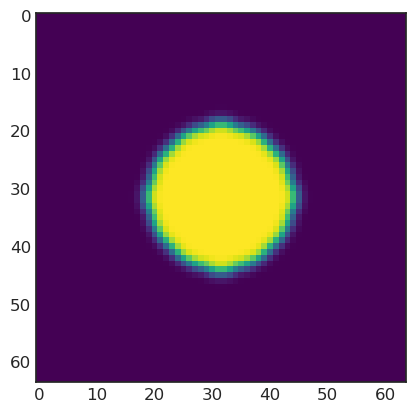

In [6]:
nlines = 100 #How many lines of data to use for training?
nltest = 60 #How many lines for the test set?
tst_strt = amp.shape[0]-nltest #Where to index from
print(tst_strt)

filt = f.lowpass_g(.6, np.ones(h), sym = True)
#filt = f.lowpass_g(.9, np.ones(h), sym = True)
# TODO assert symmetry
probe = f.gf(((np.einsum('i,j->ij', filt, filt)) > .5).astype(float), 1) + 1e-9
probe_small = probe[16:-16, 16:-16]
tprobe = (tf.convert_to_tensor(probe, tf.float32)[..., None])
tprobe_small = (tf.convert_to_tensor(probe_small, tf.float32)[..., None])

plt.imshow(probe)

N = h
assert h == w

### Load experimental dataset (currently *not* being used)

In [7]:
# from sklearn.model_selection import train_test_split

# # def blowup(img):
# #     N = img.shape[0]
# #     assert img.shape[1] == N
# #     cropped = img[N // 4: -N // 4, N // 4: -N // 4]
# #     return resize(cropped.copy(), (N, N))

# def stack(a1, a2):
#     return np.array((a1, a2)).reshape((-1, N, N, 1))

# def augment_inversion(Y_I_train, Y_phi_train):
#     phi = stack(Y_phi_train, -Y_phi_train)
# #     phi_off = np.random.uniform(size = phi.size).reshape(phi.shape)
# #     phi = np.mod(phi + phi_off)
#     return stack(Y_I_train, Y_I_train[:, ::-1, ::-1, :]), stack(Y_phi_train, -Y_phi_train)

# X_train = data_diffr_red[:nlines,:].reshape(-1,h,w)[:,:,:,np.newaxis]
# X_test = data_diffr_red[tst_strt:,tst_strt:].reshape(-1,h,w)[:,:,:,np.newaxis]
# Y_I_train = amp[:nlines,:].reshape(-1,h,w)[:,:,:,np.newaxis]
# Y_I_test = amp[tst_strt:,tst_strt:].reshape(-1,h,w)[:,:,:,np.newaxis]
# Y_phi_train = ph[:nlines,:].reshape(-1,h,w)[:,:,:,np.newaxis]
# Y_phi_test = ph[tst_strt:,tst_strt:].reshape(-1,h,w)[:,:,:,np.newaxis]

# ntrain = X_train.shape[0]*X_train.shape[1]
# ntest = X_test.shape[0]*X_test.shape[1]

# print(X_train.shape, X_test.shape)

# # # resize to fill the grid better
# # X_train = np.array([blowup(arr) for arr in X_train]) * probe[None, ..., None]
# # X_test = np.array([blowup(arr) for arr in X_test]) * probe[None, ..., None]

# tmp1, tmp2 = Y_I_train, Y_I_test

# # X_train = np.array(hh.pad_and_diffract(Y_I_train, h, w, pad=False)[1])
# # X_test = np.array(hh.pad_and_diffract(Y_I_test, h, w, pad=False)[1])

In [170]:
nphotons = 1e10

def _preprocess(sample):
    # run ff diffraction
    amplitude = hh.pad_and_diffract(sample, h, w, pad=False)[1]
#     return amplitude
    # sample from Poisson observation likelihood
    observed_amp = tf.sqrt((tfd.Independent(tfd.Poisson(amplitude**2))).sample()) + 0.5
    return observed_amp

def preprocess(Y_I_train, Y_phi_train, Y_I_test, Y_phi_test):
    Y_I_train = Y_I_train *  probe[None, ..., None]
    Y_I_test = Y_I_test *  probe[None, ..., None]

    Y_I_test /= max(Y_I_train.max(), Y_I_test.max())
    Y_I_train /= (Y_I_train.max())

    # Augment using the inversion symmetry
#     Y_I_train, Y_phi_train = augment_inversion(Y_I_train, Y_phi_train)

    prenorm_train = (Y_I_train**2).sum(axis = 3).sum(axis = 2).sum(axis = 1)
    prenorm_test = (Y_I_test**2).sum(axis = 3).sum(axis = 2).sum(axis = 1)
    
    norm_train = np.sqrt(nphotons / prenorm_train)[:, None, None, None]
    norm_test = np.sqrt(nphotons / prenorm_test)[:, None, None, None]

    Y_I_train, Y_phi_train = shuffle(norm_train * Y_I_train, Y_phi_train, random_state=0)
    Y_I_test = norm_test * Y_I_test

    obj_train = hh.combine_complex(Y_I_train, Y_phi_train)
    obj_test = hh.combine_complex(Y_I_test, Y_phi_test)

    # Simulate diffraction
    X_train = (tf.data.Dataset.from_tensor_slices(obj_train)
               .batch(batch_size)
               .prefetch(tf.data.AUTOTUNE)
               .map(_preprocess)
               .cache())
    X_train = np.vstack(list(iter(X_train)))

    X_test = (tf.data.Dataset.from_tensor_slices(obj_test)
               .batch(batch_size)
               .prefetch(tf.data.AUTOTUNE)
               .map(_preprocess)
               .cache())
    X_test = np.vstack(list(iter(X_test)))
    
    empirical_norm = max(Y_I_train.max(), Y_I_test.max())
#     Y_I_train /= (Y_I_train.max())
    return X_train / empirical_norm, Y_I_train / empirical_norm, Y_phi_train,\
        X_test / empirical_norm, Y_I_test / empirical_norm, Y_phi_test, norm_train
#     return X_train / norm_train, Y_I_train / norm_train, Y_phi_train,\
#         X_test / norm_test, Y_I_test / norm_test, Y_phi_test, norm_train

In [171]:
import datasets
from importlib import reload
reload(datasets)

<module 'datasets' from '/home/ollie/mnt/sys/Documents/scratch/ptycho/datasets.py'>

### Generate dataset based on randomly-oriented lines

In [172]:
np.random.seed(1) # TODO some seed values result in unstable training
Y_I_train = np.array([datasets.mk_lines_img() for _ in range(15000)])[:, :, :, :1]
Y_I_test = np.array([datasets.mk_lines_img() for _ in range(5000)])[:, :, :, :1]

In [173]:
Y_phi_train = np.zeros_like(Y_I_train)
Y_phi_test = np.zeros_like(Y_I_test)

# tmp = np.linspace(-np.pi, np.pi, N) / 10
tmp = np.linspace(-1, 1., N)

Y_phi_train[:] = ((tmp) * tmp[:, None] * np.pi / 2)[..., None]
Y_phi_test[:] = ((tmp) * tmp[:, None] * np.pi / 2)[..., None]

X_train, Y_I_train, Y_phi_train, X_test, Y_I_test, Y_phi_test, nt =\
    preprocess(Y_I_train, Y_phi_train, Y_I_test, Y_phi_test)

(Y_phi_test).shape, (Y_I_test).shape, Y_I_train.shape
#Y_I_train.max(axis = 3).max(axis = 2).max(axis = 1).argmax()

((5000, 64, 64, 1), (5000, 64, 64, 1), (15000, 64, 64, 1))

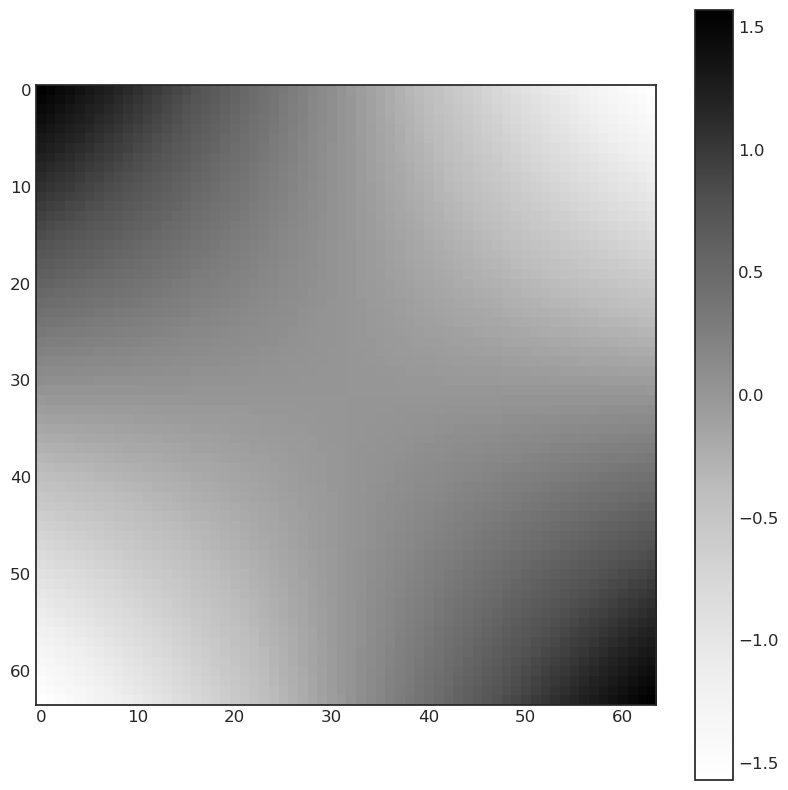

In [174]:
plt.imshow(Y_phi_train[0])
plt.colorbar()

### Norm conservation consistency check:

In [175]:
print(np.linalg.norm(X_train[0]) /  np.linalg.norm(Y_I_train[0]))

def normed_ff_np(arr):
    return (f.fftshift(np.absolute(f.fft2(np.array(arr)))) / h)

1.0000601129413251


### Inversion symmetry check:

In [176]:
import fourier as f

# assert (normed_ff_np(Y_I_train[0, :, :, 0])[::-1, ::-1] == normed_ff_np(Y_I_train[0, ::-1, ::-1, 0])).all()

normed_ff_np(Y_I_train[0, :, :, 0]).sum() / normed_ff_np(2 * Y_I_train[0, :, :, 0]).sum()

0.5

### np / tf consistency check:

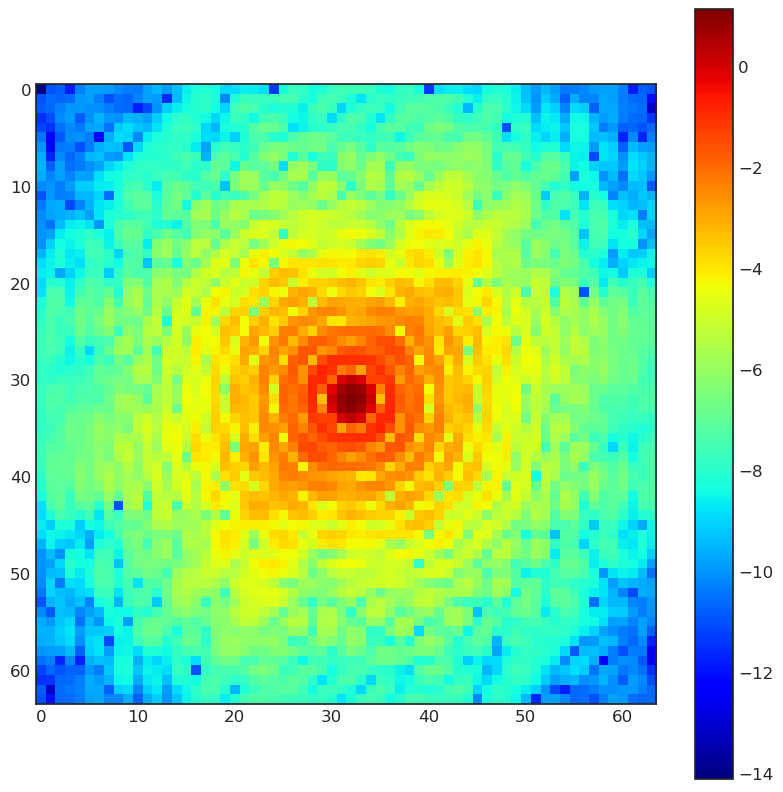

In [177]:
i = 0

plt.imshow(np.log(normed_ff_np(Y_I_train[0, :, :, 0])), cmap = 'jet')
plt.colorbar()

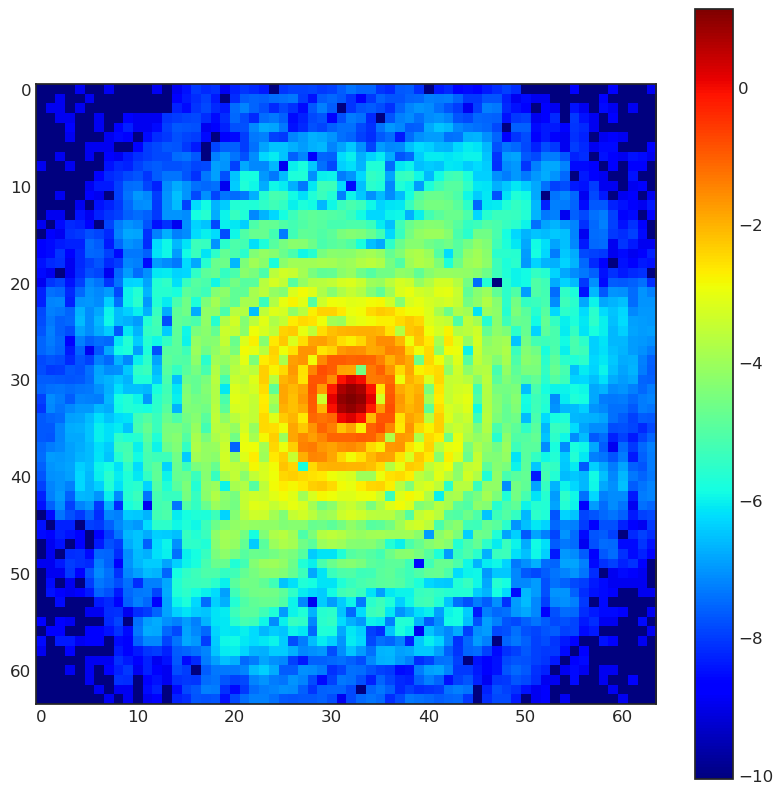

In [178]:
plt.imshow(np.log(X_train[0, :, :, 0]), cmap = 'jet')
plt.colorbar()

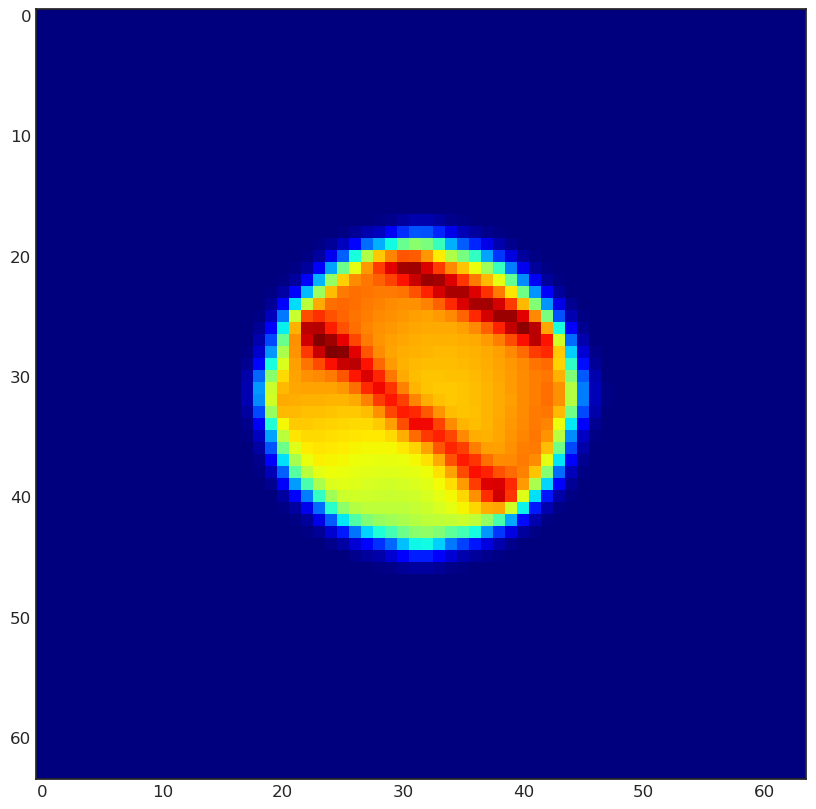

In [179]:
plt.imshow((np.squeeze(Y_I_train[i])), cmap = 'jet')

In [180]:
### Recover shift between scan points

# import numpy as np
# import scipy.signal

# def cross_image(im1, im2):
#     # get rid of the color channels by performing a grayscale transform
#     # the type cast into 'float' is to avoid overflows
#     im1_gray = im1#np.sum(im1.astype('float'), axis=2)
#     im2_gray = im2#np.sum(im2.astype('float'), axis=2)

#     # get rid of the averages, otherwise the results are not good
#     im1_gray -= np.mean(im1_gray)
#     im2_gray -= np.mean(im2_gray)

#     # calculate the correlation image; note the flipping of onw of the images
#     return scipy.signal.fftconvolve(im1_gray, im2_gray[::-1,::-1], mode='same')

### Full diffraction, no probe envelope:

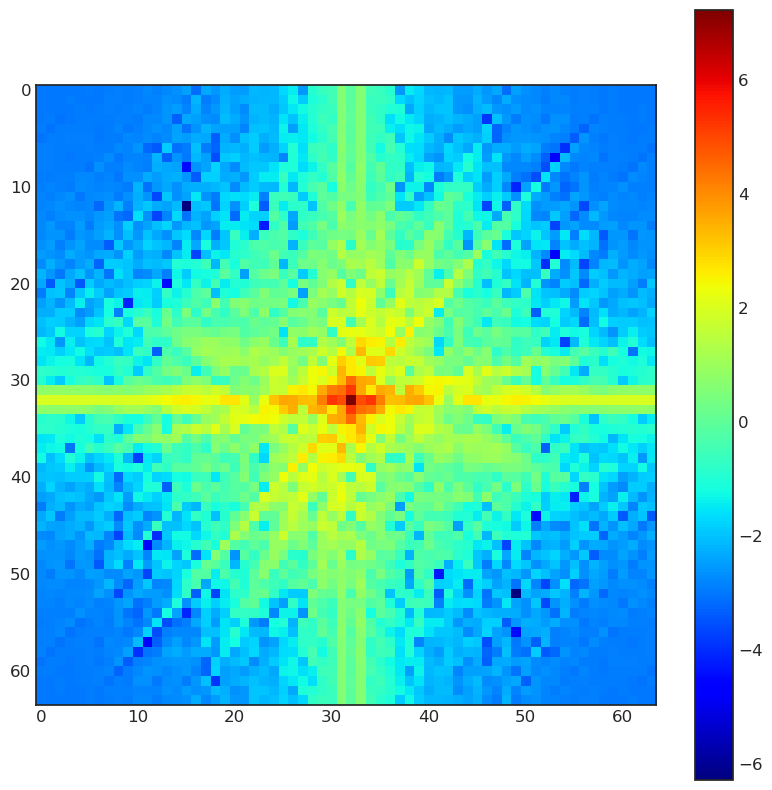

In [181]:
forward = (np.absolute(f.fftshift(f.fft2(f.gf(Y_I_train[i] / probe[..., None], 0.).squeeze()))))

plt.imshow(np.log(f.gf(forward, 0)), cmap = 'jet')
plt.colorbar()

## Define the network structure

In [182]:
dummy_input = tf.zeros_like(X_train)

In [183]:
# %load keras_helper.py
#Keras modules
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, UpSampling2D
from tensorflow.keras import Sequential
from tensorflow.keras import Input
import numpy as np



def Conv_Pool_block(x0,nfilters,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last'):
    x0 = Conv2D(nfilters, (w1, w2), activation='relu', padding=padding, data_format=data_format)(x0)
    x0 = Conv2D(nfilters, (w1, w2), activation='relu', padding=padding, data_format=data_format)(x0)
    x0 = MaxPool2D((p1, p2), padding=padding, data_format=data_format)(x0)
    return x0

def Conv_Up_block(x0,nfilters,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last',
        activation = 'relu'):
    x0 = Conv2D(nfilters, (w1, w2), activation='relu', padding=padding, data_format=data_format)(x0)
    x0 = Conv2D(nfilters, (w1, w2), activation=activation, padding=padding, data_format=data_format)(x0)
    x0 = UpSampling2D((p1, p2), data_format=data_format)(x0)
    return x0

In [184]:
from tensorflow.keras.activations import sigmoid, tanh
from tensorflow.keras.layers import Lambda

from importlib import reload
reload(hh)

import math

In [185]:
def get_mask(input, support_threshold):
    mask = tf.where(tf.math.abs(input) > support_threshold, tf.ones_like(input),
                    tf.zeros_like(input))
    
#     mask = tf.where(tprobe[16:-16, 16:-16, :] > support_threshold, tf.ones_like(input),
#                     tf.zeros_like(input))
    return mask

def symmetrize(arr):
    return (arr + arr[::-1, ::-1]) / 2

def symmetrize_3d(arr):
    return (arr + arr[:, ::-1, ::-1]) / 2



plt.rcParams["figure.figsize"] = (10, 10)

def cropshow(arr, *args, **kwargs):
    arr = arr[16:-16, 16:-16]
    plt.imshow(arr, *args, **kwargs)


def summarize(i):
    #norm =  (np.absolute(b)[i].max() / tmp2[i].max())
    # vmax = tmp2[i].max() * norm
    vmin = 0
    vmax = np.absolute(b)[i].max()

    aa, bb = 3, 3
    plt.subplot(aa, bb, 1)
    plt.title('Ground truth amp.')
    #cropshow((Y_I_test[i]), cmap = 'jet', vmin = vmin, vmax = vmax)
    cropshow((Y_I_test[i]), cmap = 'jet')

    plt.subplot(aa, bb, 2)
    plt.title('True amp. (symmetrized)')
    #cropshow((np.absolute(symmetrize(Y_I_test[i]))), cmap = 'jet', vmin = vmin, vmax = vmax)
    cropshow((np.absolute(symmetrize(Y_I_test[i]))), cmap = 'jet')

    plt.subplot(aa, bb, 3)
    plt.title('Reconstructed amp.')
    #cropshow((np.absolute(b))[i] * probe[..., None], cmap = 'jet', vmin = vmin, vmax = vmax)
    cropshow((np.absolute(b))[i] * probe[..., None], cmap = 'jet')

    plt.subplot(aa, bb, 4)
    plt.title('Reconstructed phase')
    cropshow((np.angle(b))[i], cmap = 'jet')
    
    plt.subplot(aa, bb, 5)
    plt.title('True phase')
    cropshow((Y_phi_test)[i], cmap = 'jet')
    
    plt.subplot(aa, bb, 6)
    plt.title('True diffraction')
    plt.imshow(np.log(X_test)[i], cmap = 'jet')
    
    plt.subplot(aa, bb, 7)
    plt.title('Recon diffraction')
    plt.imshow(np.log(a)[i], cmap = 'jet')
    
def plt_metrics():
    hist=history
    epochs=np.asarray(history.epoch)+1

    %matplotlib inline
    import matplotlib
    plt.style.use('seaborn-white')
    matplotlib.rc('font',family='Times New Roman')
    matplotlib.rcParams['font.size'] = 12

    f, axarr = plt.subplots(2, sharex=True, figsize=(12, 8))

    axarr[0].set(ylabel='Loss')
    axarr[0].plot(epochs,hist.history['loss'], 'C3o', label='Diffraction perceptual loss Training')
    axarr[0].plot(epochs,hist.history['val_loss'], 'C3-', label='Diffraction perceptual loss Validation')
    axarr[0].grid()
    axarr[0].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

    axarr[1].set(ylabel='Loss')
    axarr[1].plot(epochs,hist.history['padded_obj_loss'], 'C0o', label='Object perceptual loss Training')
    axarr[1].plot(epochs,hist.history['val_padded_obj_loss'], 'C0-', label='Object perceptual loss Validation')
    axarr[1].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
    plt.xlabel('Epochs')
    plt.tight_layout()
    #plt.semilogy()
    axarr[1].grid()

In [186]:
#plt.imshow(tprobe[16:-16, 16:-16, :] > .05)

In [187]:
from tensorflow.keras.applications.vgg16 import VGG16

# vgg = VGG16(weights='imagenet', include_top=False, input_shape=(N // 2,N // 2,3))
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(N, N, 3))
vgg.trainable = False

outputs = [vgg.get_layer('block2_conv2').output]
feat_model = Model(vgg.input, outputs)

# @tf.function
# def perceptual_loss(input_image , reconstruct_image):
#     h1 = feat_model(input_image)
#     h2 = feat_model(reconstruct_image)

#     h1 = tf.keras.backend.batch_flatten(h1)
#     h2 = tf.keras.backend.batch_flatten(h2)
#     rc_loss = tf.sum(K.square(h1 - h2), axis=-1)
#     return rc_loss

def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

def high_pass_x_y(image):
    x_var = image[:,:,1:,:] - image[:,:,:-1,:]
    y_var = image[:,1:,:,:] - image[:,:-1,:,:]
    return x_var, y_var

def total_variation_loss(target, pred):
#     target = tf.keras.layers.AveragePooling2D(padding = 'valid')(target)
    pred = tf.keras.layers.AveragePooling2D(padding = 'valid')(pred)

    x_deltas, y_deltas = high_pass_x_y(pred)
    return tf.reduce_mean(x_deltas**2) + tf.reduce_mean(y_deltas**2)

def pp_amplitude(img):
    return img#tf.math.log(1 + 10 * img)

def perceptual_loss(target, pred):
    """
    Takes N X N images but does average pooling to remove high-frequency components
    """
#     pp = tfk.Sequential([
#         Lambda(lambda x: tf.image.grayscale_to_rgb(x)),
#         tf.keras.layers.AveragePooling2D()
#     ])

#     target = pp(target)
#     target = tf.keras.layers.AveragePooling2D(padding = 'valid')(target)
#     target = pp_amplitude(target)
    target = tf.image.grayscale_to_rgb(target)

#     pred = pp(pred)
#     pred = tf.keras.layers.AveragePooling2D(padding = 'valid')(pred)
#     pred = pp_amplitude(pred)
    pred = tf.image.grayscale_to_rgb(pred)
    
    activatedModelVal = feat_model(pred)
    actualModelVal = feat_model(target)
    return meanSquaredLoss(gram_matrix(actualModelVal),gram_matrix(activatedModelVal))

def amplitude_difference(target, pred):
    """
    Calculate object MAE, taking into account that the prediction may be inverted
    """
    abs1 = tf.math.abs(target)
    abs2 = tf.math.abs(pred)
    abs3 = abs2[:, ::-1, ::-1, :]
    target_sym = tf.math.abs(symmetrize_3d(target))
    mae = tf.keras.losses.MeanAbsoluteError()
    a, b, c = mae(abs1, abs2), mae(abs1, abs3), mae(target_sym, pred)
    return tf.minimum(a, 
                      tf.minimum(b, c))

def meanSquaredLoss(y_true,y_pred):
    return tf.reduce_mean(tf.keras.losses.MSE(y_true,y_pred))
# perceptual_loss(tf.convert_to_tensor(X_test[:50]), tf.convert_to_tensor(X_test[:50]))

In [188]:
tprobe_small = tprobe[16:-16, 16:-16, :]

In [189]:
reload(hh)

<module 'tf_helper' from '/home/ollie/mnt/sys/Documents/scratch/ptycho/tf_helper.py'>

In [195]:
tf.keras.backend.clear_session()
np.random.seed(2)

files=glob.glob('%s/*' %wt_path)
for file in files:
    os.remove(file)

input_img = Input(shape=(h, w, 1), name = 'input') 

x = Conv_Pool_block(input_img,32,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last')
x = Conv_Pool_block(x,64,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last')
x = Conv_Pool_block(x,128,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last')

encoded=x

#Decoding arm for amplitude
x1=Conv_Up_block(encoded,128,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
x1=Conv_Up_block(x1,64,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
#x1=Conv_Up_block(x1,32,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')

decoded1 = Conv2D(1, (3, 3), padding='same')(x1)
decoded1 = Lambda(lambda x: sigmoid(x), name='amp')(decoded1)


#Decoding arm for phase
x2=Conv_Up_block(encoded,128,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
x2=Conv_Up_block(x2,64,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
#x2=Conv_Up_block(x2,32,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')

decoded2 = Conv2D(1, (3, 3), padding='same')(x2)
decoded2 = Lambda(lambda x: math.pi * tanh(x), name='phi')(decoded2)

# decoded2 = Lambda(lambda x: (np.random.uniform() - .5) * math.pi * 2 + x)(decoded2)

obj = Lambda(lambda x: hh.combine_complex(x[0], x[1]),
                     name='obj')([decoded1, decoded2])
obj = Lambda(lambda x: tf.cast(tprobe_small, tf.complex64) * x)(obj)

# # Add real space support
# support = Lambda(lambda x: get_mask(x, .02), name='support')(decoded1)
# obj = Lambda(lambda x: x[0] * tf.cast(x[1], tf.complex64),
#                             name='masked_obj')([obj, support])

# Diffracted amplitude
padded_obj, pred_diff = hh.pad_and_diffract(obj, h, w)

# pred_diff = Lambda(lambda x: tf.math.log(1 + 10 * x))(pred_diff)


encoder = tf.keras.Model(inputs=[input_img],
                           outputs=[padded_obj])

# TODO add noise that respects nyquist criterion
def mul_gaussian_noise(image):
    # image must be scaled in [0, 1]
    with tf.name_scope('Add_gaussian_noise'):
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=1, dtype=tf.float32)
        noise_img = image * noise
    return noise_img

noisy_diff = mul_gaussian_noise(pred_diff)
feedback_obj = encoder(
    noisy_diff)

feedback_loss = tf.keras.losses.MeanAbsoluteError(name = 'foo')(padded_obj, feedback_obj)


# autoencoder = Model([input_img], [pred_diff, padded_obj, feedback_loss])
autoencoder = Model([input_img], [pred_diff, padded_obj, pred_diff])

# # Make an auxiliary model that exposes the real space object reconstruction
# obj_layer_out = autoencoder.get_layer('obj').output
# aux_model = tf.keras.Model(inputs=autoencoder.inputs,
#                            outputs=[noisy_diff, feedback_obj])

In [196]:
def dummy_loss(target, pred):
    return pred

In [197]:
# # The second output exposes the real space object reconstruction but does not contribue to the training loss,
# # but it's used to calculate reconstruction errors for validation
# autoencoder.compile(optimizer='adam', loss=['mean_absolute_error', amplitude_difference, 'feedback_loss'],
#                     loss_weights = [0., 0., 1.]

# #                     loss_weights = [1., 0.]
# #                     {autoencoder.outputs[0].name.split('/')[0]: 'mean_absolute_error'}
#                    )

# The second output exposes the real space object reconstruction but does not contribue to the training loss,
# but it's used to calculate reconstruction errors for validation
autoencoder.compile(optimizer='adam',
     loss=[perceptual_loss, perceptual_loss, 'mean_absolute_error'],
     loss_weights = [0., 0., 1.]
#      loss_weights = [2e-1, 0., 1.]
                    
#      loss=[perceptual_loss, perceptual_loss, total_variation_loss],
#      loss_weights = [5e-1, 0., 1.]
                    
#      loss=['mean_absolute_error', amplitude_difference, dummy_loss],
#      loss_weights = [1., 0., 0.]

                   )

print (autoencoder.summary())
#plot_model(autoencoder, to_file='paper_data/str_model.png')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   320         ['input[0][0]']                  
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 32)   0           ['conv2d_1[0][0]']               
                                                                                            

In [202]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.0001, verbose=1)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

checkpoints= tf.keras.callbacks.ModelCheckpoint('%s/weights.{epoch:02d}.h5' %wt_path, 
                                            monitor='val_loss', verbose=1, save_best_only=True, 
                                            save_weights_only=False, mode='auto', period=1)


history=autoencoder.fit([X_train], [X_train, Y_I_train, X_train], shuffle=True, batch_size=batch_size, verbose=1, 
                           epochs=17, validation_split = 0.05, callbacks=[reduce_lr, earlystop, checkpoints])

# history=autoencoder.fit([X_train], [X_train, Y_I_train, dummy_input], shuffle=True, batch_size=batch_size, verbose=1, 
#                            epochs=2, validation_split = 0.05, callbacks=[reduce_lr, earlystop, checkpoints])

a, b, loss = autoencoder.predict([X_test])

Epoch 1/17
445/446 [============================>.] - ETA: 0s - loss: 0.0022 - pred_amplitude_loss: 0.0339 - padded_obj_loss: 1.8608 - pred_amplitude_1_loss: 0.0022
Epoch 1: val_loss improved from inf to 0.00204, saving model to wts4.1/weights.01.h5
446/446 [==============================] - 9s 21ms/step - loss: 0.0022 - pred_amplitude_loss: 0.0339 - padded_obj_loss: 1.8608 - pred_amplitude_1_loss: 0.0022 - val_loss: 0.0020 - val_pred_amplitude_loss: 0.0308 - val_padded_obj_loss: 1.8540 - val_pred_amplitude_1_loss: 0.0020 - lr: 0.0010
Epoch 2/17
445/446 [============================>.] - ETA: 0s - loss: 0.0020 - pred_amplitude_loss: 0.0272 - padded_obj_loss: 1.8683 - pred_amplitude_1_loss: 0.0020
Epoch 2: val_loss improved from 0.00204 to 0.00198, saving model to wts4.1/weights.02.h5
446/446 [==============================] - 9s 21ms/step - loss: 0.0020 - pred_amplitude_loss: 0.0272 - padded_obj_loss: 1.8683 - pred_amplitude_1_loss: 0.0020 - val_loss: 0.0020 - val_pred_amplitude_loss: 

Epoch 16/17
445/446 [============================>.] - ETA: 0s - loss: 0.0014 - pred_amplitude_loss: 0.0120 - padded_obj_loss: 1.8805 - pred_amplitude_1_loss: 0.0014
Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0001.

Epoch 16: val_loss improved from 0.00142 to 0.00141, saving model to wts4.1/weights.16.h5
446/446 [==============================] - 9s 21ms/step - loss: 0.0014 - pred_amplitude_loss: 0.0120 - padded_obj_loss: 1.8804 - pred_amplitude_1_loss: 0.0014 - val_loss: 0.0014 - val_pred_amplitude_loss: 0.0132 - val_padded_obj_loss: 1.8734 - val_pred_amplitude_1_loss: 0.0014 - lr: 1.2500e-04
Epoch 17/17
445/446 [============================>.] - ETA: 0s - loss: 0.0014 - pred_amplitude_loss: 0.0118 - padded_obj_loss: 1.8877 - pred_amplitude_1_loss: 0.0014
Epoch 17: val_loss improved from 0.00141 to 0.00140, saving model to wts4.1/weights.17.h5
157/157 [==============================] - 1s 4ms/step


In [32]:
Y_I_train.max()

0.9836652109558787

### 10^10 photons, MAE objective:

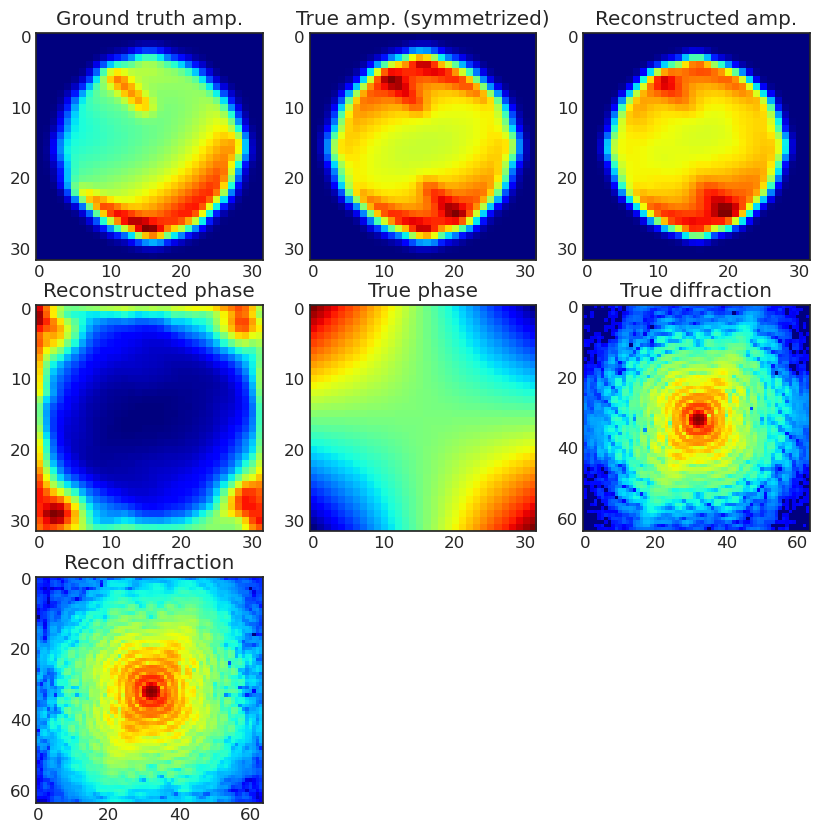

In [120]:
summarize(20)

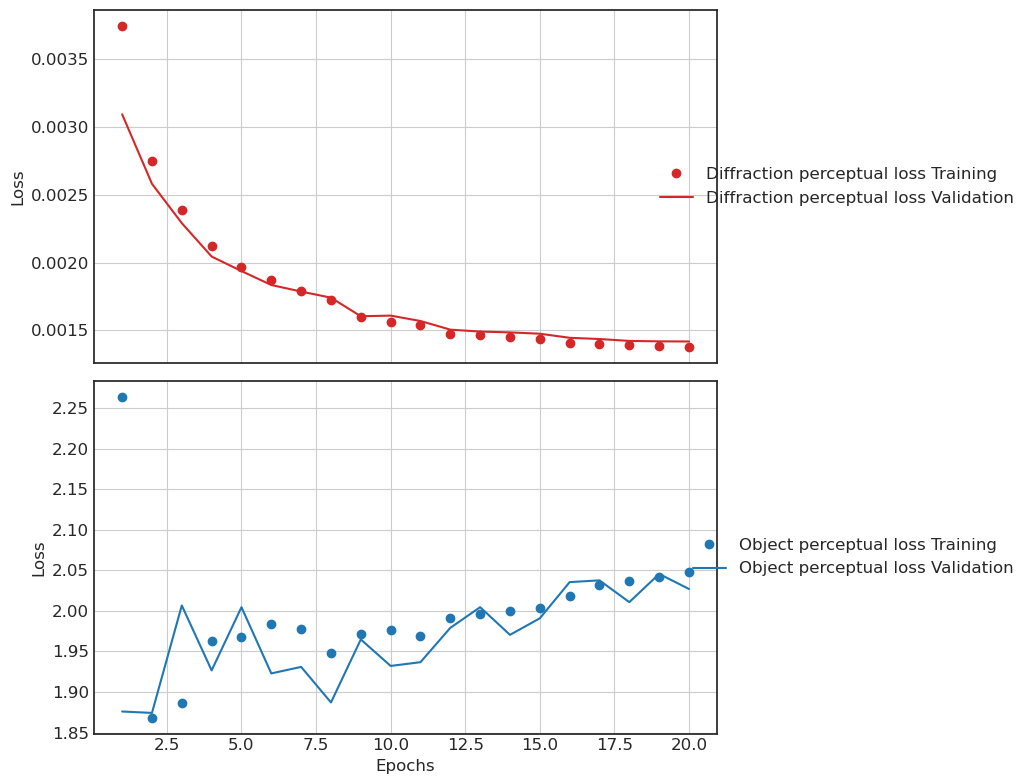

In [121]:
plt_metrics()

### 10^8 photons, MAE loss:

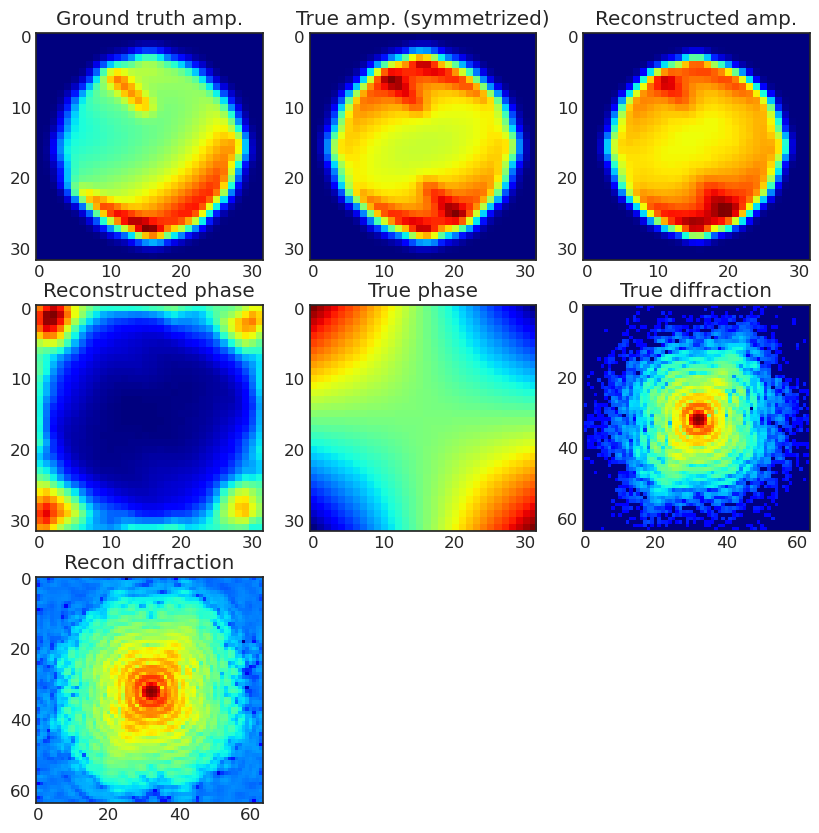

In [152]:
summarize(20)

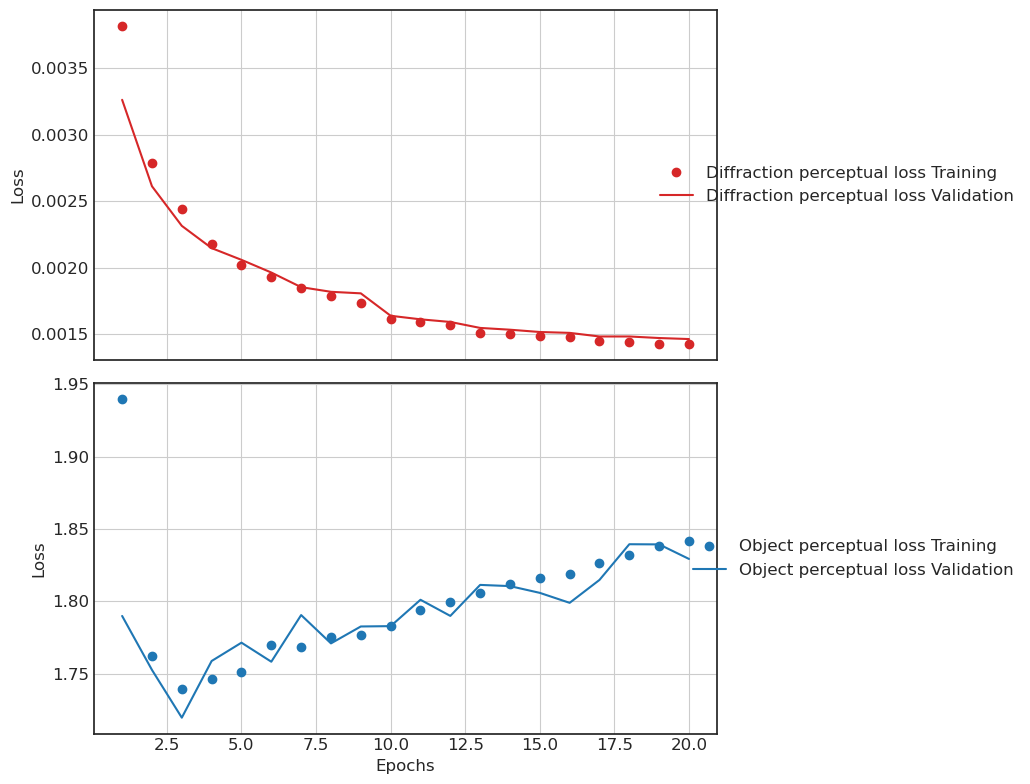

In [153]:
plt_metrics()

### 10^10 photons, perceptual loss:

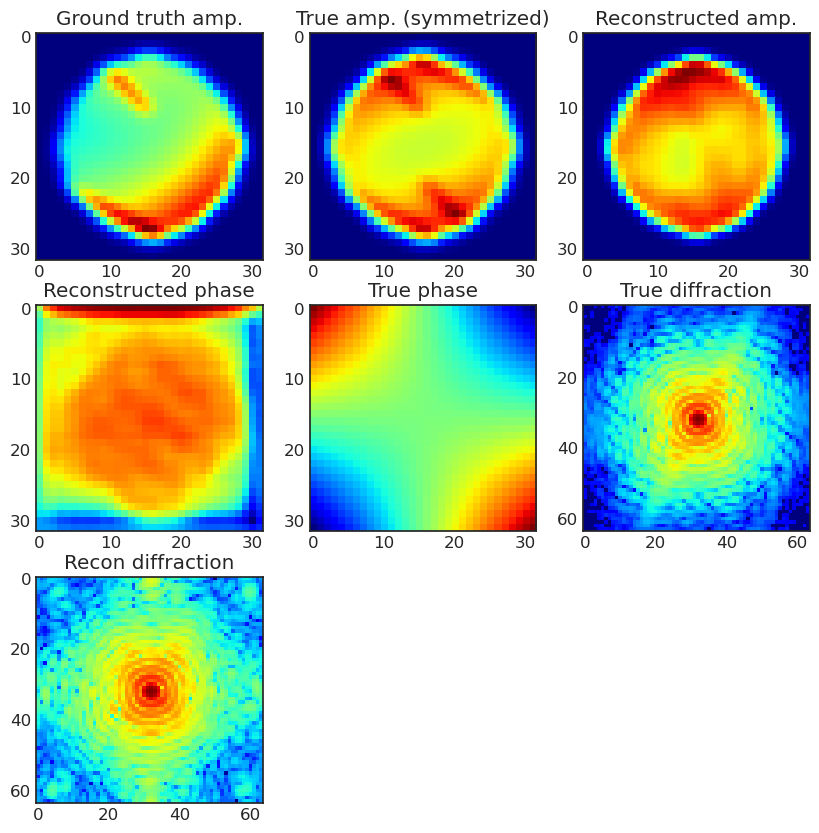

In [126]:
summarize(20)

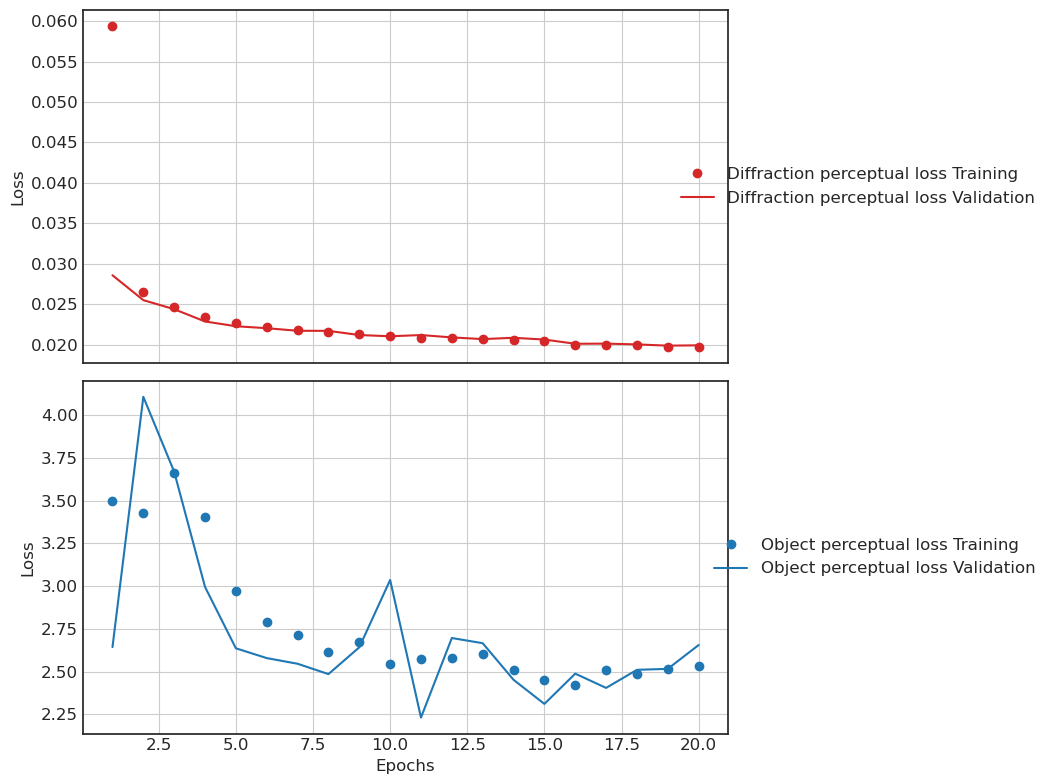

In [127]:
plt_metrics()

### 10^8 photons, perceptual loss:

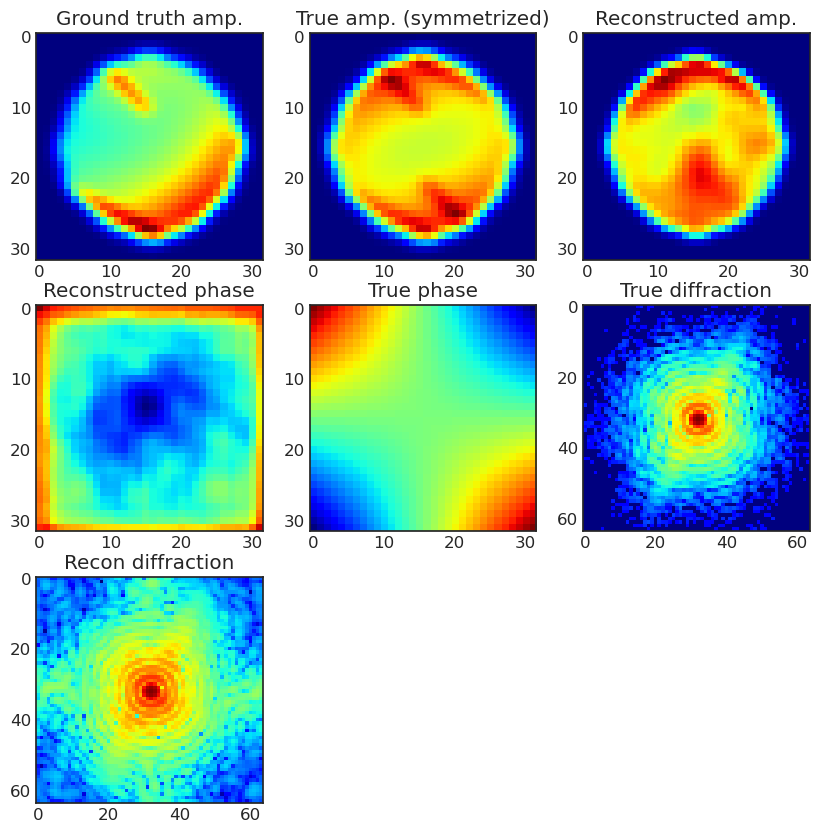

In [168]:
summarize(20)

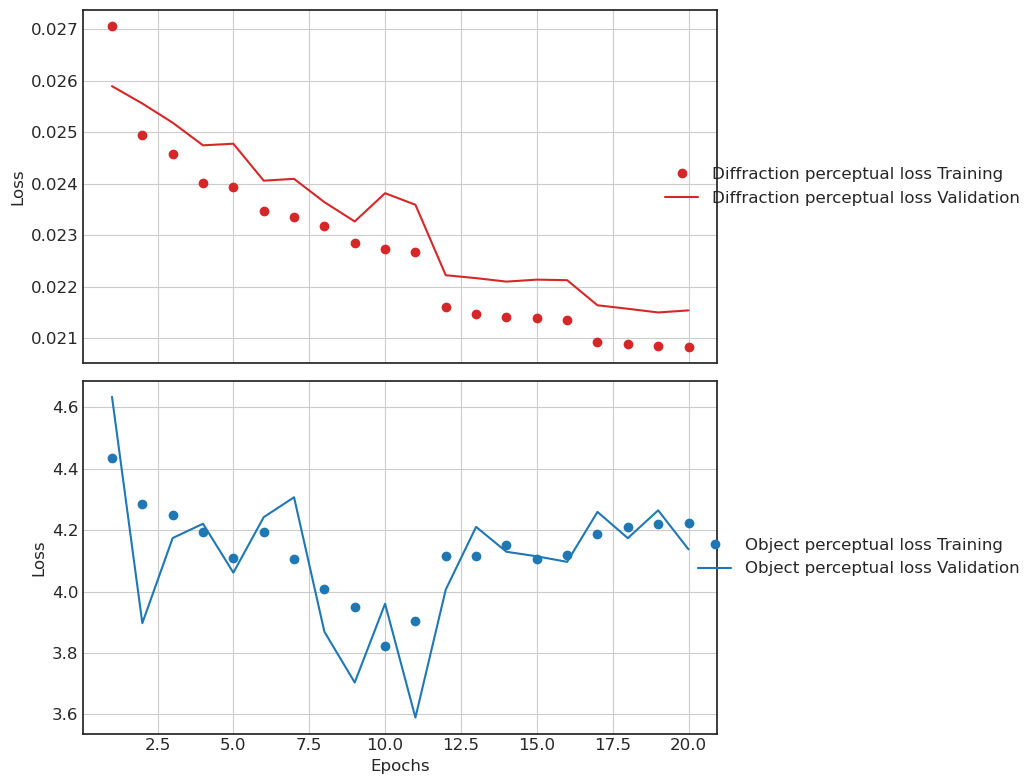

In [169]:
plt_metrics()

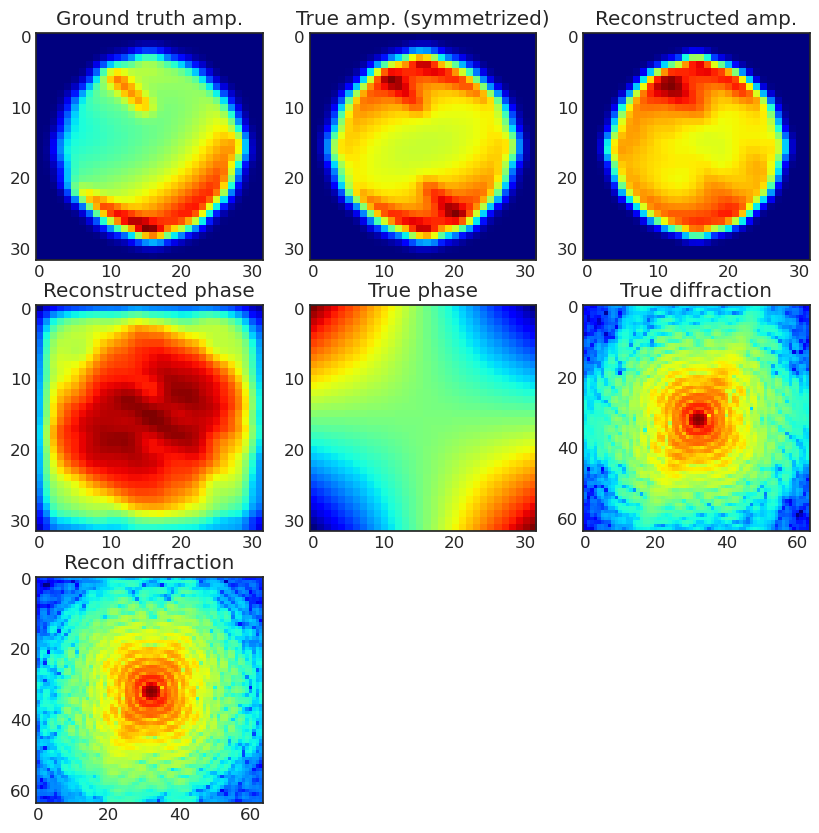

In [72]:
# a, b, loss = autoencoder.predict([X_test])
summarize(20)

### More examples of reconstructions:

In [ ]:
i = 501

In [ ]:
summarize(i)

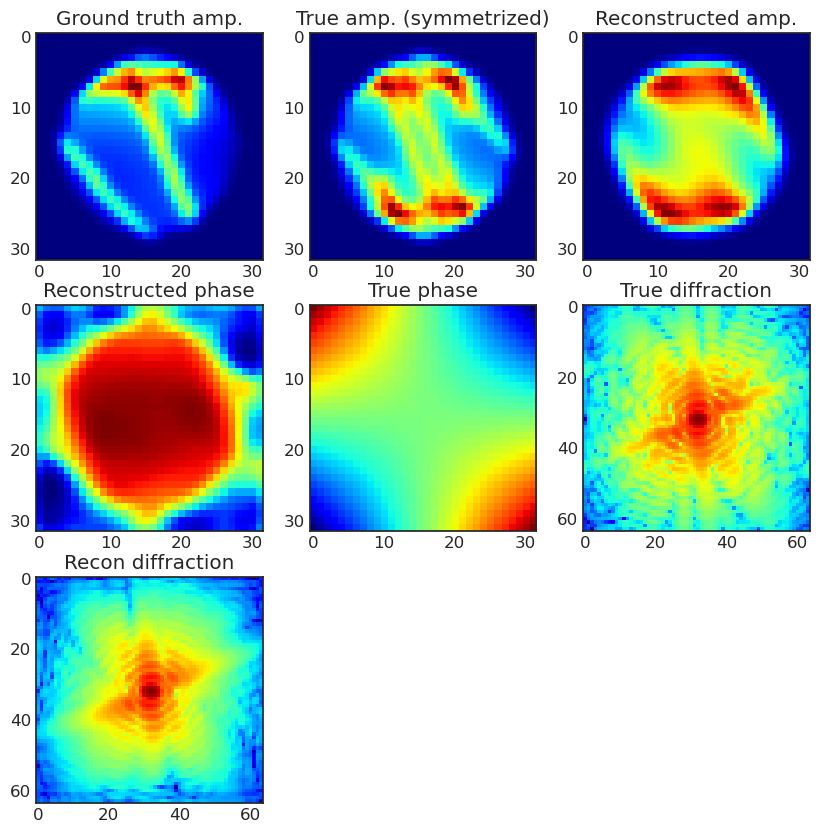

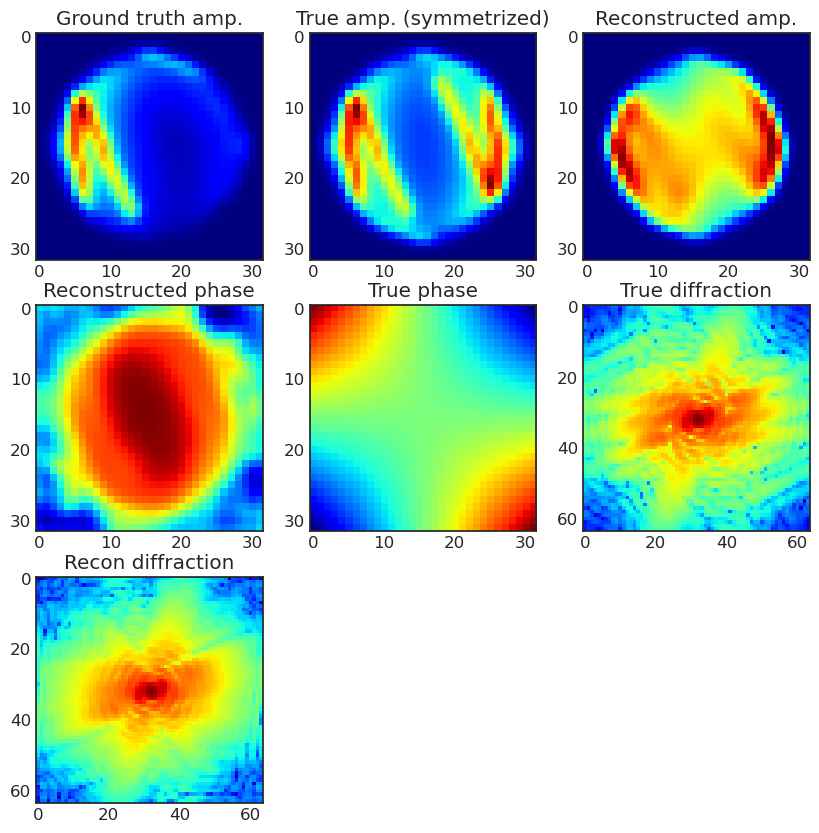

In [49]:
summarize(505)

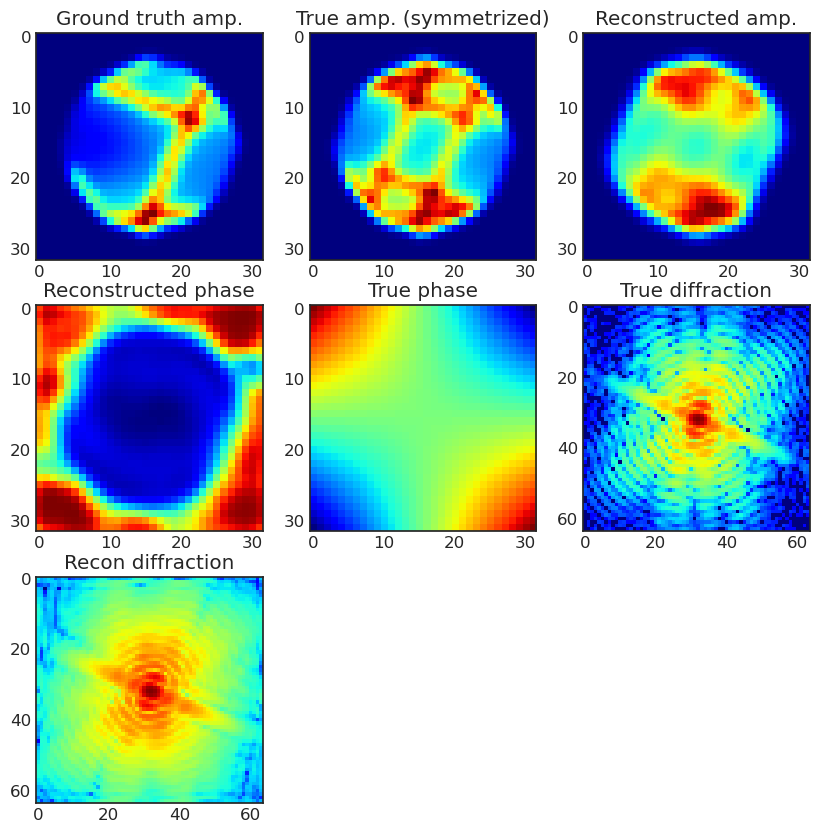

In [92]:
summarize(505)

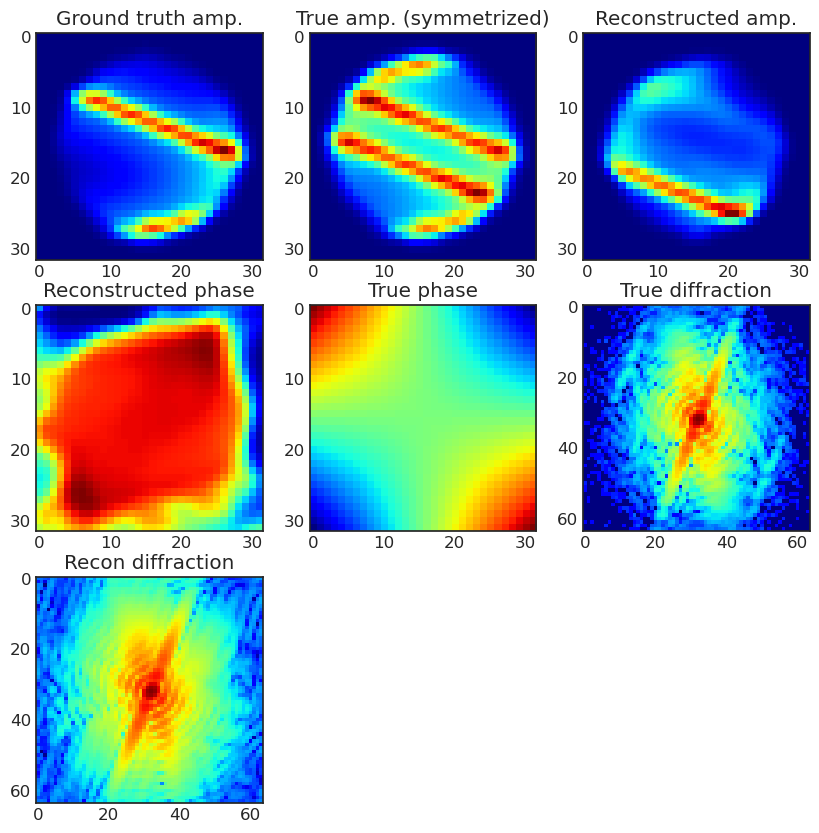

In [48]:
summarize(505)

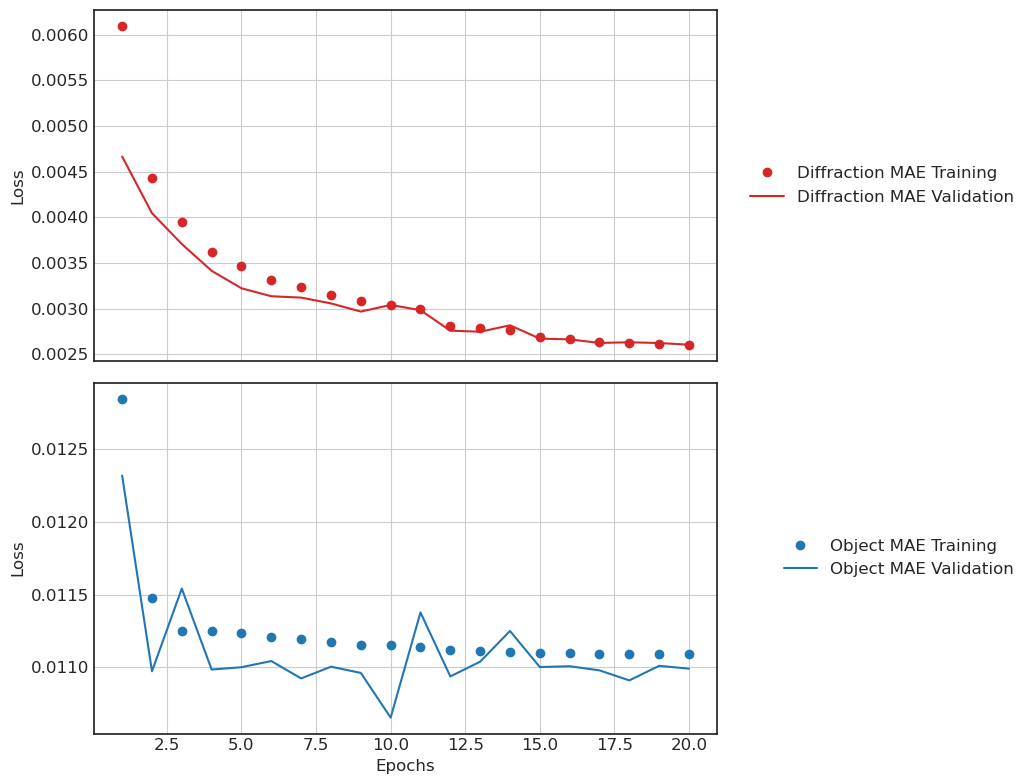

In [52]:
plt_metrics()

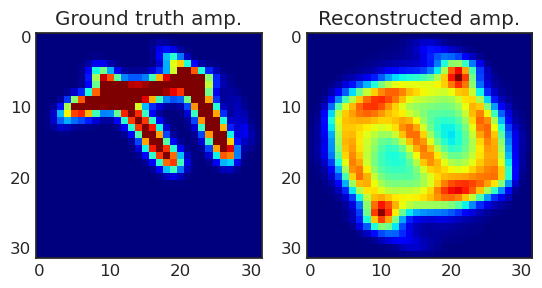

In [88]:
def cropshow(arr, *args, **kwargs):
    arr = arr[16:-16, 16:-16]
    plt.imshow(arr, *args, **kwargs)
    
off = 1
norm =  (np.absolute(b)[i].max() / tmp2[i].max())
# vmax = tmp2[i].max() * norm
vmin = 0
vmax = np.absolute(b)[i].max()

aa, bb = 1, 2
plt.subplot(aa, bb, 1)
plt.title('Ground truth amp.')
cropshow((Y_I_test[i]), cmap = 'jet', vmin = vmin, vmax = vmax)

plt.subplot(aa, bb, 2)
plt.title('Reconstructed amp.')
cropshow((np.absolute(b))[i], cmap = 'jet', vmin = vmin, vmax = vmax)
# plt.colorbar()

In [54]:
noisy, no = aux_model([X_test[:100]])

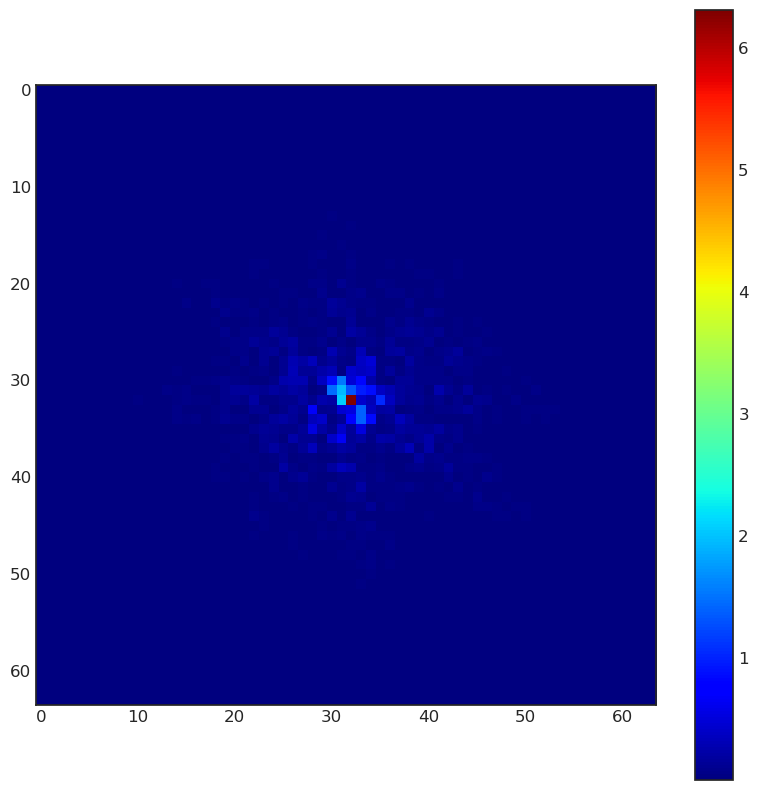

In [55]:
plt.imshow(np.absolute(noisy)[0], cmap = 'jet')
plt.colorbar()

In [56]:
c, d, _ = autoencoder.predict([noisy])

4/4 [==============================] - 0s 26ms/step


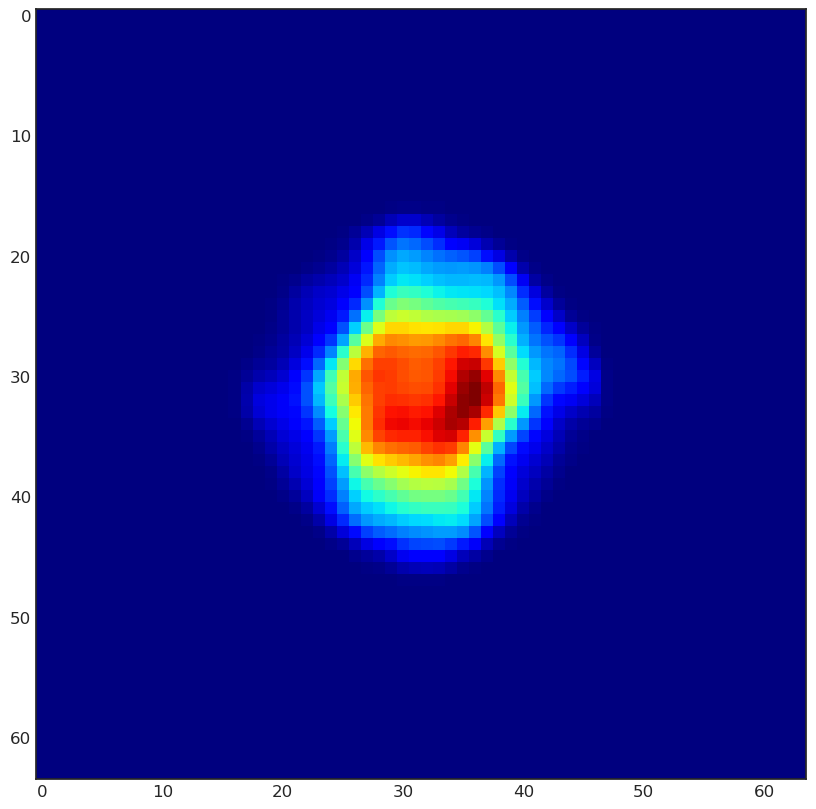

In [57]:
plt.imshow(np.absolute(d)[0], cmap = 'jet')

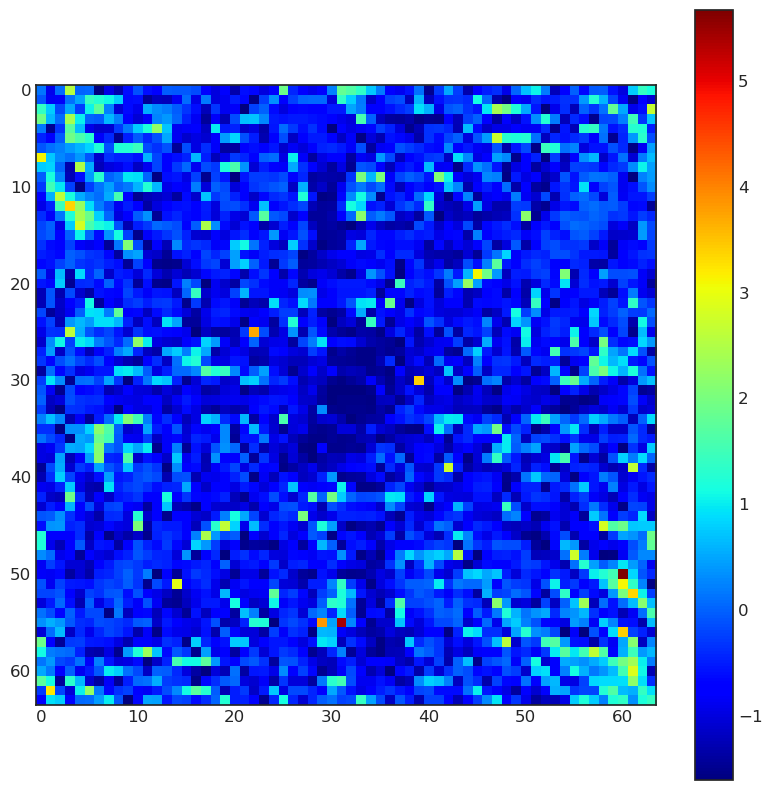

In [58]:
plt.imshow(np.log(.2 + np.abs((a[i] - X_test[i]) / (X_test[i] + 1e-9))), cmap ='jet')
plt.colorbar()

In [71]:
tmp2 = Y_I_test

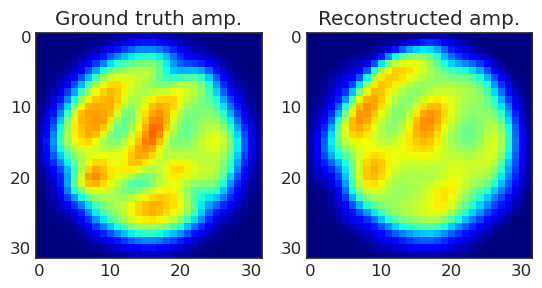

In [46]:
off = 1
norm =  (np.absolute(b)[i].max() / tmp2[i].max())
# vmax = tmp2[i].max() * norm
vmin = 0
vmax = 1

aa, bb = 1, 2
plt.subplot(aa, bb, 1)
plt.title('Ground truth amp.')
cropshow((Y_I_test[i]), cmap = 'jet', vmin = vmin, vmax = vmax)

plt.subplot(aa, bb, 2)
plt.title('Reconstructed amp.')
cropshow((np.absolute(b))[i], cmap = 'jet', vmin = vmin, vmax = vmax)
# plt.colorbar()

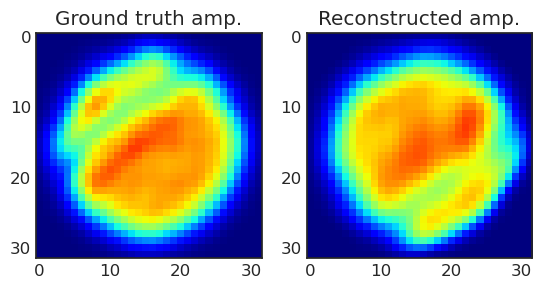

In [36]:
off = 1
norm =  (np.absolute(b)[i].max() / tmp2[i].max())
# vmax = tmp2[i].max() * norm
vmin = 0
vmax = 1

aa, bb = 1, 2
plt.subplot(aa, bb, 1)
plt.title('Ground truth amp.')
cropshow((Y_I_test[i]), cmap = 'jet', vmin = vmin, vmax = vmax)

plt.subplot(aa, bb, 2)
plt.title('Reconstructed amp.')
cropshow((np.absolute(b))[i], cmap = 'jet', vmin = vmin, vmax = vmax)
# plt.colorbar()

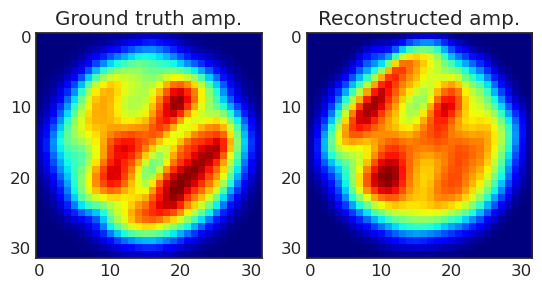

In [37]:
off = 1
norm =  (np.absolute(b)[i].max() / tmp2[i].max())
vmax = tmp2[i].max() * norm

aa, bb = 1, 2
plt.subplot(aa, bb, 1)
plt.title('Ground truth amp.')
cropshow((Y_I_test[i]), cmap = 'jet', vmax = vmax)

plt.subplot(aa, bb, 2)
plt.title('Reconstructed amp.')
cropshow((np.absolute(b))[i], cmap = 'jet', vmax = vmax)
# plt.colorbar()

In [38]:
amplitude_difference(Y_I_test[i:i + 1], (np.absolute(b)[i:i + 1]))

tf.Tensor(0.014161492, shape=(), dtype=float32) tf.Tensor(0.012130551, shape=(), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=0.012130551>

In [62]:
# !ln ../xrd_clustering/notebooks/visualization.py

In [199]:
import visualization as vis
# reload(vis)

In [200]:
vmin = np.min(Y_I_test[:, 16:-16, 16:-16][i:i + 10])
vmax = np.max(Y_I_test[:, 16:-16, 16:-16][i:i + 10])

3 epochs

diffraction reconstruction


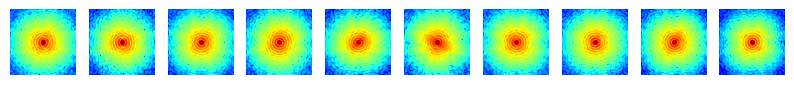

object reconstruction (amp)


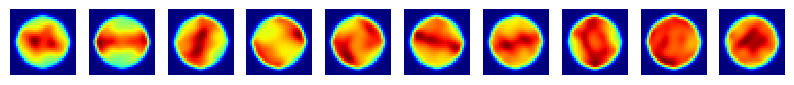

object reconstruction (phase)


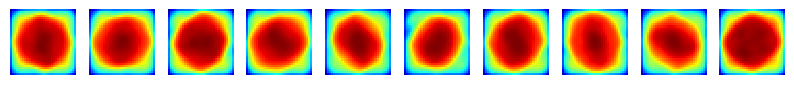

object ground truth (symmetric)


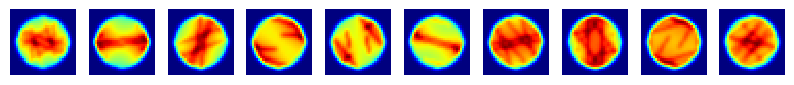

object ground truth


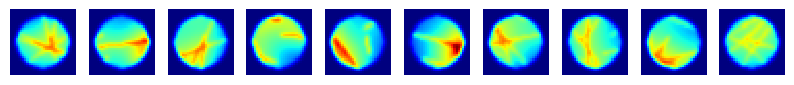

In [201]:
print('diffraction reconstruction')
vis.display_imgs(np.log(np.absolute(a))[i:i + 10])
print('object reconstruction (amp)')
vis.display_imgs(np.absolute(b[:, 16:-16, 16:-16])[i:i + 10])#, vmin = vmin, vmax = vmax)
print('object reconstruction (phase)')
vis.display_imgs(np.angle(b[:, 16:-16, 16:-16])[i:i + 10])#, vmin = vmin, vmax = vmax)
print('object ground truth (symmetric)')
vis.display_imgs(np.absolute(symmetrize_3d(Y_I_test[:, 16:-16, 16:-16]))[i:i + 10])#, vmin = vmin, vmax = vmax)
print('object ground truth')
vis.display_imgs(Y_I_test[:, 16:-16, 16:-16][i:i + 10], vmin = vmin, vmax = vmax)

20 epochs:

diffraction reconstruction


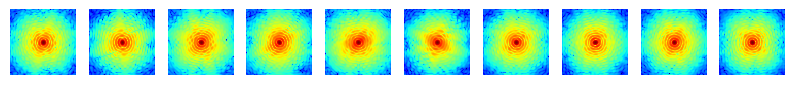

object reconstruction (amp)


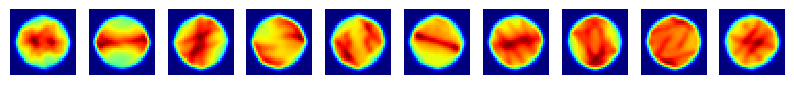

object reconstruction (phase)


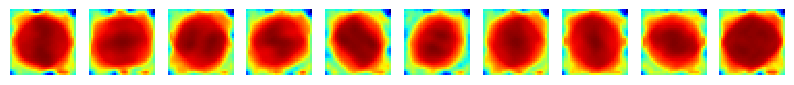

object ground truth (symmetric)


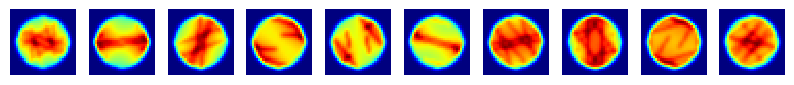

object ground truth


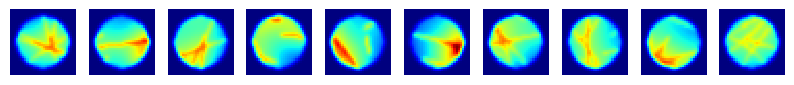

In [203]:
print('diffraction reconstruction')
vis.display_imgs(np.log(np.absolute(a))[i:i + 10])
print('object reconstruction (amp)')
vis.display_imgs(np.absolute(b[:, 16:-16, 16:-16])[i:i + 10])#, vmin = vmin, vmax = vmax)
print('object reconstruction (phase)')
vis.display_imgs(np.angle(b[:, 16:-16, 16:-16])[i:i + 10])#, vmin = vmin, vmax = vmax)
print('object ground truth (symmetric)')
vis.display_imgs(np.absolute(symmetrize_3d(Y_I_test[:, 16:-16, 16:-16]))[i:i + 10])#, vmin = vmin, vmax = vmax)
print('object ground truth')
vis.display_imgs(Y_I_test[:, 16:-16, 16:-16][i:i + 10], vmin = vmin, vmax = vmax)

diffraction reconstruction


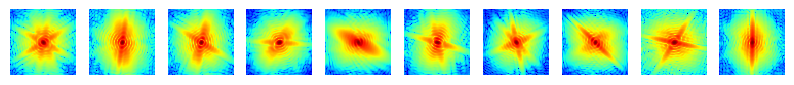

object reconstruction (amp)


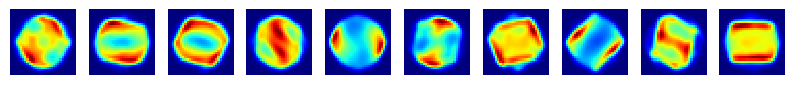

object reconstruction (phase)


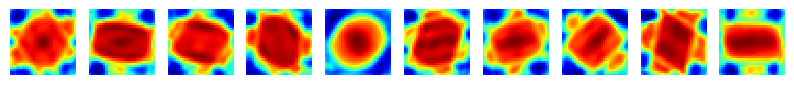

object ground truth (symmetric)


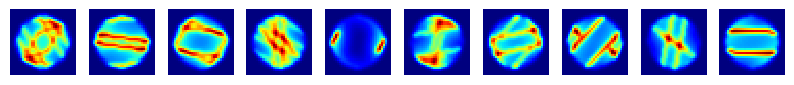

object ground truth


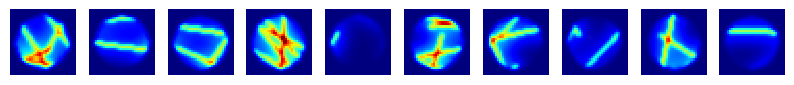

In [80]:
print('diffraction reconstruction')
vis.display_imgs(np.log(np.absolute(a))[i:i + 10])
print('object reconstruction (amp)')
vis.display_imgs(np.absolute(b[:, 16:-16, 16:-16])[i:i + 10])#, vmin = vmin, vmax = vmax)
print('object reconstruction (phase)')
vis.display_imgs(np.angle(b[:, 16:-16, 16:-16])[i:i + 10])#, vmin = vmin, vmax = vmax)
print('object ground truth (symmetric)')
vis.display_imgs(np.absolute(symmetrize_3d(Y_I_test[:, 16:-16, 16:-16]))[i:i + 10])#, vmin = vmin, vmax = vmax)
print('object ground truth')
vis.display_imgs(Y_I_test[:, 16:-16, 16:-16][i:i + 10], vmin = vmin, vmax = vmax)

diffraction reconstruction


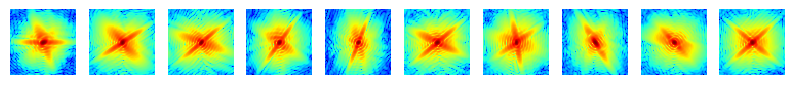

object reconstruction (amp)


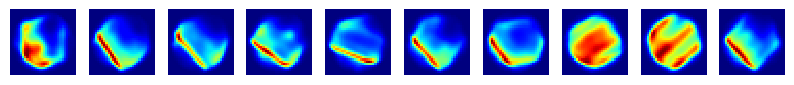

object reconstruction (phase)


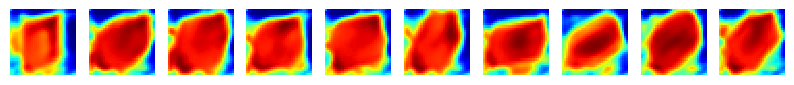

object ground truth (symmetric)


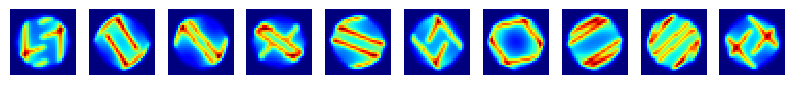

object ground truth


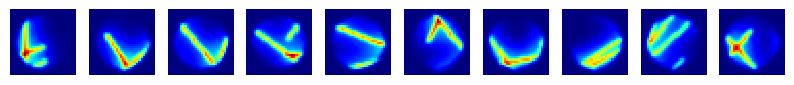

In [53]:
print('diffraction reconstruction')
vis.display_imgs(np.log(np.absolute(a))[i:i + 10])
print('object reconstruction (amp)')
vis.display_imgs(np.absolute(b[:, 16:-16, 16:-16])[i:i + 10])#, vmin = vmin, vmax = vmax)
print('object reconstruction (phase)')
vis.display_imgs(np.angle(b[:, 16:-16, 16:-16])[i:i + 10])#, vmin = vmin, vmax = vmax)
print('object ground truth (symmetric)')
vis.display_imgs(np.absolute(symmetrize_3d(Y_I_test[:, 16:-16, 16:-16]))[i:i + 10])#, vmin = vmin, vmax = vmax)
print('object ground truth')
vis.display_imgs(Y_I_test[:, 16:-16, 16:-16][i:i + 10], vmin = vmin, vmax = vmax)

ground truth


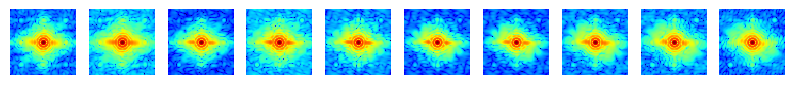

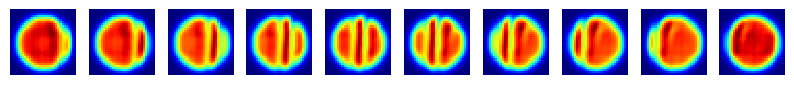

reconstruction


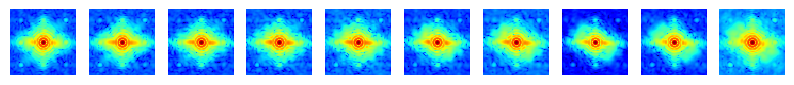

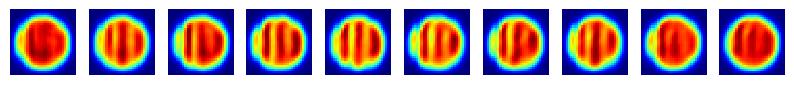

In [180]:
i = 800
print('ground truth')
vis.display_imgs(np.log(X_test[i:i + 10]))
vis.display_imgs(Y_I_test[:, 16:-16, 16:-16][i:i + 10])


print('reconstruction')
vis.display_imgs(np.log(np.absolute(a))[i:i + 10])
vis.display_imgs(np.absolute(b[:, 16:-16, 16:-16])[i:i + 10])

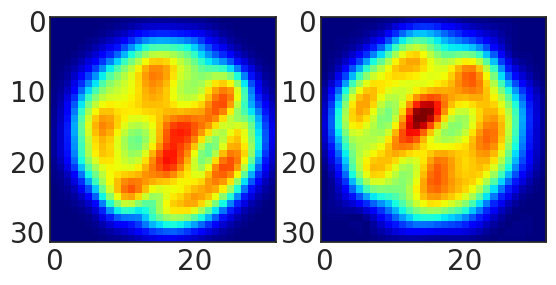

In [110]:
off = 1
i = 607

aa, bb = 1, 2
plt.subplot(aa, bb, 1)
plt.imshow((Y_I_test[i, 16:-16, 16:-16]), cmap = 'jet', vmax = vmax)

plt.subplot(aa, bb, 2)
plt.imshow((np.absolute(b))[i], cmap = 'jet', vmax = vmax)
# plt.colorbar()

## Training metrics

In [75]:
hist.history.keys()

dict_keys(['loss', 'lambda_3_loss', 'padded_obj_loss', 'tf.math.divide_no_nan_loss', 'val_loss', 'val_lambda_3_loss', 'val_padded_obj_loss', 'val_tf.math.divide_no_nan_loss', 'lr'])

In [76]:
np.save(path+'str_history', history.history)

In [59]:
# model.load_weights(checkpoint_filepath)

'wts4.1/weights.03.h5'

In [77]:
# val_losses=hist.history['val_loss']
# min_epoch=np.argmin(val_losses)+1
# print (min_epoch)
# np.save(path+'%s/min_epoch' %(wt_path), min_epoch)
autoencoder.save('{}.h5'.format(wt_path))